In [1]:
import numpy as np
import ctypes
import pyautogui

from PIL import Image, ImageDraw
import decimal

from pytesseract import pytesseract
import pandas as pd
from tqdm import tqdm
import time
import mss
import mss.tools
from screeninfo import get_monitors

In [2]:
monitor_x_offset = 1920
monitor_y_offset = -7

In [3]:
def get_screen():
    img = None
    with mss.mss() as sct:
        # Get information of monitor 2
        monitor_number = 2
        mon = sct.monitors[monitor_number]

        # The screen part to capture
        monitor = {
            "top": mon["top"],
            "left": mon["left"],
            "width": mon["width"],
            "height": mon["height"],
            "mon": monitor_number,
        }
        output = "sct-mon{mon}_{top}x{left}_{width}x{height}.png".format(**monitor)

        # Grab the data
        img = np.array(sct.grab(monitor))
        img = Image.fromarray(img)
        return img

def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
        
def cell_dims(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def cell_dims_from_list(list_onbj):
    return cell_dims(list_onbj[0], list_onbj[1], list_onbj[2], list_onbj[3])

def get_survey_scan_results_box():
    return [1282, 612, 1842, 770] #x,y Top Left ,x,y Bottom Right

def get_cargo_box():
    return [372, 638, 630, 643] #x,y Top Left ,x,y Bottom Right

def get_locations_box():
    return [863, 135, 1326, 460] #x,y Top Left ,x,y Bottom Right

def get_row_points(box = get_survey_scan_results_box(), num_of_scanned_rows = 6):
    space = (box[3] - box[1]) / num_of_scanned_rows
    row_points= list(drange(box[1], box[3], f'{space}'))
    final_row_points = list(np.rint(np.asarray(row_points)).astype(int))
    return final_row_points

def get_col_points(box = get_survey_scan_results_box(), cols_points = None):
    if cols_points == None:
        col_delta = box[2] - box[0]
        cols_points =  [col_delta * .05, col_delta * .45, col_delta * .15, col_delta * .18]

    temp_list = []
    for i in range(len(cols_points)):
        this_int = box[0]
        for j in range(i + 1):
            this_int += cols_points[j]
        temp_list.append(this_int)

    final_col_points = np.array(temp_list)
    final_col_points = list(np.rint(final_col_points).astype(int))
    final_col_points = [box[0]] + final_col_points + [box[2]]
    return final_col_points

def get_cells(x_range, y_range):
    cells = {}
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            try:
                cells[i, j] = tuple([x, y, x + x_range[i+1], y + y_range[j+1]])
            except:
                pass
    return cells

def render_outline(img, x_range, y_range):
    img_copy = img.copy()
    img = ImageDraw.Draw(img_copy)  

    # box
    img.line([get_survey_scan_results_box()[0], get_survey_scan_results_box()[1], get_survey_scan_results_box()[0], get_survey_scan_results_box()[3]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[0], get_survey_scan_results_box()[3], get_survey_scan_results_box()[2], get_survey_scan_results_box()[3]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[2], get_survey_scan_results_box()[3], get_survey_scan_results_box()[2], get_survey_scan_results_box()[1]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[2], get_survey_scan_results_box()[1], get_survey_scan_results_box()[0], get_survey_scan_results_box()[1]], fill ="red", width = 5)
    # rows
    for i in y_range:
        img.line([get_survey_scan_results_box()[0], i, get_survey_scan_results_box()[2], i], fill="#ff6600", width=1)
    # cols
    for i in x_range:
        img.line([i, get_survey_scan_results_box()[1], i, get_survey_scan_results_box()[3]], fill="#ff6600", width=1)  
    return img_copy

def extract_values(img, cells, x_range, y_range, columns = ['Locked', 'Ore', 'Quantity', 'Volume', 'Distance', 'click_target']):
    global monitor_x_offset
    global monitor_y_offset
    frames = []
    for i in tqdm(range(len(y_range)-1)):
        frame = {}
        for j in range(0, len(x_range) - 1):
            cell = cell_dims_from_list(list(cells[j, i]))
            cell_image = img.crop(cell)

            transcript = pytesseract.image_to_string(cell_image, lang='eng')

            frame[columns[j]] = transcript.replace('\n','').replace('+','').replace('>','').replace('k m', ' km').replace(',','')
        frame['click_target'] = (cells[0, i][0] + 60 - monitor_x_offset, cells[0, i][1] + 15 - monitor_y_offset) # offset by 10x10 pixels
        frames.append(frame)
    df = pd.DataFrame(frames, columns=columns)
    return df

def convert_to_baw(img, thresh = 140):
    fn = lambda x : 255 if x > thresh else 0
    img = img.convert('L').point(fn, mode='1')
    return img

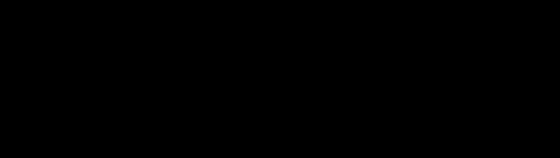

In [4]:
full_screen_image = get_screen()
convert_to_baw(full_screen_image.crop(get_survey_scan_results_box()))

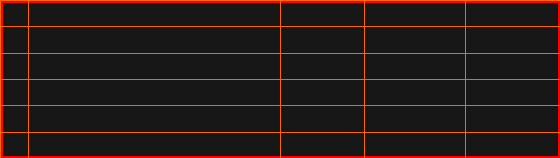

In [5]:
x_range = get_col_points()
y_range = get_row_points()

cells = get_cells(x_range, y_range)

img = render_outline(full_screen_image, x_range, y_range)
img.crop(get_survey_scan_results_box())

In [6]:
extract_values(img, cells, x_range, y_range)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.73it/s]


,Locked,Ore,Quantity,Volume,Distance,click_target
0,,,,,,"(-578, 634)"
1,,,,,,"(-578, 660)"
2,,,,,,"(-578, 687)"
3,,,,,,"(-578, 713)"
4,,,,,,"(-578, 739)"
5,,,,,,"(-578, 766)"


In [7]:
def process():   
    img = get_screen()
    
    cargo_bar = convert_to_baw(img.crop(get_cargo_box()), thresh = 20)
    
    img_array = np.array(cargo_bar)
    cargo_percent_full = len(img_array[img_array==True]) / (len(img_array[img_array==True]) + len(img_array[img_array==False]))
    print(f'Percent Cargo Full {cargo_percent_full: .2f}')

    scan_x_range = get_col_points()
    scan_y_range = get_row_points()
    scan_cells = get_cells(scan_x_range, scan_y_range)
    scan_df = extract_values(img, scan_cells, scan_x_range, scan_y_range)

    loc_x_range = get_col_points(box = get_locations_box(), cols_points = [1])
    loc_y_range = get_row_points(box = get_locations_box(), num_of_scanned_rows=13)
    loc_cells = get_cells(loc_x_range[1:3], loc_y_range)
    loc_df = extract_values(img, loc_cells, loc_x_range[1:3], loc_y_range, columns=['Name', 'click_target'])

    scan_df.loc[scan_df['Locked'] != '', 'Locked'] = '><'
    return scan_df, loc_df, cargo_percent_full

In [8]:
process()

Percent Cargo Full  0.12


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.86it/s]


(  Locked Ore Quantity Volume Distance click_target
 0                                      (-578, 634)
 1                                      (-578, 660)
 2                                      (-578, 687)
 3                                      (-578, 713)
 4                                      (-578, 739)
 5                                      (-578, 766),
         Name click_target
 0       Home  (-996, 157)
 1      POS 1  (-996, 182)
 2      POS 1  (-996, 207)
 3      POS 2  (-996, 232)
 4      POS 2  (-996, 257)
 5      POS 3  (-996, 282)
 6      POS 3  (-996, 307)
 7      POS 4  (-996, 332)
 8   Site1 PL  (-996, 357)
 9   Site1 P2  (-996, 382)
 10  Site1 P3  (-996, 407)
 11  Site1 P4  (-996, 432),
 0.12403100775193798)

In [9]:
scan_df, loc_df, cargo_percent_full = process()

Percent Cargo Full  0.12


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.83it/s]


# Models
https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata  
C:\Program Files\Tesseract-OCR\tessdata

In [10]:
time.sleep(0.5)

pyautogui.moveTo(1122 - monitor_x_offset, 900 - monitor_y_offset)
time.sleep(0.1)
pyautogui.click(button='left')

time.sleep(7)

for l in range(100):
    print('checking...')
    scan_df, loc_df, cargo_percent_full = process()
    
    if cargo_percent_full < .80:  
        snap_df = scan_df[scan_df['Quantity'].str.len()>0][0:2]
        snap_df = snap_df[~snap_df['Locked'].str.contains('><')]
        indicies = snap_df.index
        if len(indicies) == 2:
            print('starting 2x...')
            for i in indicies:
                pyautogui.moveTo(scan_df.loc[i, 'click_target'])
                time.sleep(0.1)
                pyautogui.keyDown('ctrl')
                time.sleep(0.1)
                pyautogui.click()
                time.sleep(0.1)
                pyautogui.keyUp('ctrl')
                time.sleep(1)
            time.sleep(4)
            xy=None
            for i, index in enumerate(indicies):
                xy = scan_df.loc[index, 'click_target']
                pyautogui.moveTo(xy)
                time.sleep(0.1)
                pyautogui.click()
                time.sleep(0.1)
                pyautogui.press(f'f{i + 1}')
                time.sleep(1)
            xy = (xy[0], xy[1]-200)
            pyautogui.moveTo(xy)
            print('started...')
            time.sleep(175)
        else:
            print('skipping...')
            time.sleep(10)
    else:
        target = 'Home'

        xy = loc_df.loc[loc_df['Name']==target, 'click_target'].values[0]

        pyautogui.moveTo(xy)
        time.sleep(0.1)
        pyautogui.click(button='right')
        time.sleep(0.1)
        pyautogui.moveTo(xy[0] + 50, xy[1] + 25)
        time.sleep(0.1)
        pyautogui.click(button='left')
        time.sleep(0.1)
        pyautogui.moveTo(1, 1)
        
        time.sleep(120)
        
        pyautogui.moveTo(300 - monitor_x_offset, 626 - monitor_y_offset)
        time.sleep(0.1)
        pyautogui.dragTo(790 - monitor_x_offset, 913 - monitor_y_offset, 1,  button='left')
        time.sleep(0.1)
        pyautogui.moveTo(336 - monitor_x_offset, 672 - monitor_y_offset)
        time.sleep(0.1)
        pyautogui.dragTo(182 - monitor_x_offset, 811 - monitor_y_offset, 1,  button='left')
        time.sleep(0.1)
        pyautogui.moveTo(1757 - monitor_x_offset, 378 - monitor_y_offset)
        time.sleep(0.1)
        pyautogui.click(button='left')
        
        time.sleep(60)
        
        target = 'Site1 P2'

        xy = loc_df.loc[loc_df['Name']==target, 'click_target'].values[0]

        pyautogui.moveTo(xy)
        time.sleep(0.1)
        pyautogui.click(button='right')
        time.sleep(0.1)
        pyautogui.moveTo(xy[0] + 50, xy[1] + 25)
        time.sleep(0.1)
        pyautogui.click(button='left')
        time.sleep(0.1)
        pyautogui.moveTo(1, 1)
        
        time.sleep(120)

checking...
Percent Cargo Full  0.12


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.55it/s]


starting 2x...
started...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.15it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.98it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.11it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.71it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.21it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.92it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.20it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.06it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.10it/s]


skipping...
checking...
Percent Cargo Full  0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.13it/s]


skipping...
checking...
Percent Cargo Full  0.33


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.46it/s]


starting 2x...
started...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.09it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.20it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.06it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.22it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.01it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.99it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.05it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.19it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.93it/s]


skipping...
checking...
Percent Cargo Full  0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.15it/s]


skipping...
checking...
Percent Cargo Full  0.52


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.33it/s]


starting 2x...
started...
checking...
Percent Cargo Full  0.63


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]


skipping...
checking...
Percent Cargo Full  1.00


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.79it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
target = 'Home'

xy = loc_df.loc[loc_df['Name']==target, 'click_target'].values[0]

pyautogui.moveTo(xy)
time.sleep(0.1)
pyautogui.click(button='right')
time.sleep(0.1)
pyautogui.moveTo(xy[0] + 50, xy[1] + 25)
time.sleep(0.1)
pyautogui.click(button='left')
time.sleep(0.1)
pyautogui.moveTo(1, 1)

time.sleep(120)

pyautogui.moveTo(300 - monitor_x_offset, 626 - monitor_y_offset)
time.sleep(0.1)
pyautogui.dragTo(790 - monitor_x_offset, 913 - monitor_y_offset, 1,  button='left')
time.sleep(0.1)
pyautogui.moveTo(336 - monitor_x_offset, 672 - monitor_y_offset)
time.sleep(0.1)
pyautogui.dragTo(182 - monitor_x_offset, 811 - monitor_y_offset, 1,  button='left')
time.sleep(0.1)
pyautogui.moveTo(1757 - monitor_x_offset, 378 - monitor_y_offset)
time.sleep(0.1)
pyautogui.click(button='left')

time.sleep(60)

target = 'Site1 P2'

xy = loc_df.loc[loc_df['Name']==target, 'click_target'].values[0]

pyautogui.moveTo(xy)
time.sleep(0.1)
pyautogui.click(button='right')
time.sleep(0.1)
pyautogui.moveTo(xy[0] + 50, xy[1] + 25)
time.sleep(0.1)
pyautogui.click(button='left')
time.sleep(0.1)
pyautogui.moveTo(1, 1)

time.sleep(120)

In [ ]:
pyautogui.FAILSAFE = True